In [1]:
import numpy as np
import pandas as pd
import cobra
import scipy.stats as stats
from statsmodels.stats.multitest import fdrcorrection
from collections import Counter
from re import sub
from function_mapping_transcriptome_data_JW import map_transcriptome_data
from cobra.io import read_sbml_model
import math
from statistics import mean
from scipy.stats import mannwhitneyu
from OUTLIERS import smirnov_grubbs as grubbs
from scipy.stats import f_oneway

#For visualization
import matplotlib.pyplot as plt
import seaborn as sns
import upsetplot as up
import plotly.express as px

#For PCA
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize, LabelEncoder, MinMaxScaler

In [7]:
# Import data
phases_int = [[4],
          [5],
          [6, 7, 8],
          [11, 12, 14]
         ]

transcriptomeData = pd.read_csv("DesEq2_counts_wDE_genes.csv",
                                    dtype = {'GeneID': 'str'})
# Import model
model = read_sbml_model('iCHO2441_221-107_producing.xml')
model_genes = [x.id for x in model.genes]

# Filter transcriptome data for significantly changing genes
transcriptomeData_sig = pd.concat([
    transcriptomeData["GeneID"],
    transcriptomeData.filter(regex=r"^B", axis=1)],
    axis = 1
)

# Wrangle data to get mean of replicates for each time phase.
transcriptomeData_sig_long = pd.melt(transcriptomeData_sig, id_vars = ["GeneID"], var_name = "day", value_name = "normCounts")
transcriptomeData_sig_long["day"] = [int(sub(r"[_D]", "", x[5:7])) for x in transcriptomeData_sig_long["day"]]
transcriptomeData_sig_long_mean = transcriptomeData_sig_long.groupby(['GeneID', 'day'], as_index=False).mean()
transcriptomeData_sig_mean = transcriptomeData_sig_long_mean.pivot_table(index='GeneID', columns='day', values='normCounts').reset_index()

# Scaling function
def scaled_df(df, min_value, max_value):
    scaled = min_value + (df - df.min()) * (max_value - min_value) / (df.max() - df.min())
    return(scaled)
#Scale data
transcriptomeData_sig_scaled = pd.concat([transcriptomeData_sig_mean.GeneID,
                                        scaled_df(transcriptomeData_sig_mean.iloc[:,1:], 0, 1.5)],
                                        axis=1
                                        )
transcriptomeData_sig_scaled = transcriptomeData_sig_scaled[transcriptomeData_sig_scaled["GeneID"].isin(model_genes)]
transcriptomeData_sig_scaled


,GeneID,4,5,6,7,8,11,12,14
0,100682529,0.015225,0.007564,0.015873,0.012461,0.010100,0.009099,0.008765,0.011515
2,100682536,0.027030,0.011267,0.027871,0.027996,0.029836,0.033719,0.031036,0.038352
6,100689021,0.010883,0.003652,0.011468,0.008308,0.006238,0.005754,0.005460,0.005938
7,100689025,0.040545,0.024470,0.037453,0.028440,0.023011,0.018675,0.016024,0.019653
11,100689030,0.011972,0.005265,0.012948,0.011652,0.011128,0.010769,0.009360,0.011522
...,...,...,...,...,...,...,...,...,...
8787,103162885,0.006531,0.002136,0.007595,0.005510,0.005839,0.006767,0.006374,0.007005
8788,103162917,0.005109,0.001684,0.005549,0.004118,0.002912,0.002015,0.001773,0.002469
8796,103163371,0.000090,0.000079,0.000071,0.000066,0.000016,0.000009,0.000004,0.000007
9172,3979182,0.421317,0.425455,0.409427,0.442409,0.436882,0.369286,0.371785,0.349828


In [68]:
# Integrate data in models, exactly the same as was done for flux sampling.
def integrate_data(phase, transcriptomeData_sig_scaled=transcriptomeData_sig_scaled, model = model, model_genes = model_genes):
    print("Constrain model for phase {0}".format(phase))
    dat = transcriptomeData_sig_scaled.loc[:, ["GeneID"] + phase]

    if len(dat.columns) > 2:
        dat["value"] = dat.loc[:,phase].mean(axis=1)
        dat = dat.loc[:, ["GeneID", "value"]]
    else:
        dat.rename(columns={phase[0]: 'value'}, inplace=True)

    transcripts = dat.set_index('GeneID')['value'].to_dict()

    for i in model_genes:
        if i not in transcripts.keys():
            transcripts[i] = 1000

    cloned_model = model.copy()

    model_tr = map_transcriptome_data(cloned_model,transcripts)
    return(model_tr)

constrained_models = {}
for i in phases_int:
    constrained_models[str(i)] = integrate_data(i)

# Run FBA for comparison to flux sampling results.
fba_solutions = {}
for i in constrained_models.keys():
    fba_solutions[i] = constrained_models[i].optimize()    

Constrain model for phase [4]
Cases no genes: 2064
Cases single gene: 2028
Cases 'OR' only: 1554
Cases 'AND' only: 564
Cases 'OR' and 'AND': 127
Total number of reactions that will be constrained: 4273
Total number of reactions that won't be constrained: 2064 (And: 0 ; Or: 0 ; AndOr: 0 )
Constrain model for phase [5]
Cases no genes: 2064
Cases single gene: 2028
Cases 'OR' only: 1554
Cases 'AND' only: 564
Cases 'OR' and 'AND': 127
Total number of reactions that will be constrained: 4273
Total number of reactions that won't be constrained: 2064 (And: 0 ; Or: 0 ; AndOr: 0 )
Constrain model for phase [6, 7, 8]
Cases no genes: 2064
Cases single gene: 2028
Cases 'OR' only: 1554
Cases 'AND' only: 564
Cases 'OR' and 'AND': 127
Total number of reactions that will be constrained: 4273
Total number of reactions that won't be constrained: 2064 (And: 0 ; Or: 0 ; AndOr: 0 )
Constrain model for phase [11, 12, 14]
Cases no genes: 2064
Cases single gene: 2028
Cases 'OR' only: 1554
Cases 'AND' only: 564

In [4]:
constrained_4 = constrained_models['[4]']
%store constrained_4

constrained_5 = constrained_models['[5]']
%store constrained_5

constrained_678 = constrained_models['[6, 7, 8]']
%store constrained_678

constrained_111214 = constrained_models['[11, 12, 14]']
%store constrained_111214

Stored 'constrained_4' (Model)
Stored 'constrained_5' (Model)
Stored 'constrained_678' (Model)
Stored 'constrained_111214' (Model)


In [5]:
constrained_models

{'[4]': <Model iCHO2441_221107_producing at 0x1c741873d90>,
 '[5]': <Model iCHO2441_221107_producing at 0x1c741c2dad0>,
 '[6, 7, 8]': <Model iCHO2441_221107_producing at 0x1c737bc6150>,
 '[11, 12, 14]': <Model iCHO2441_221107_producing at 0x1c76346dc10>}

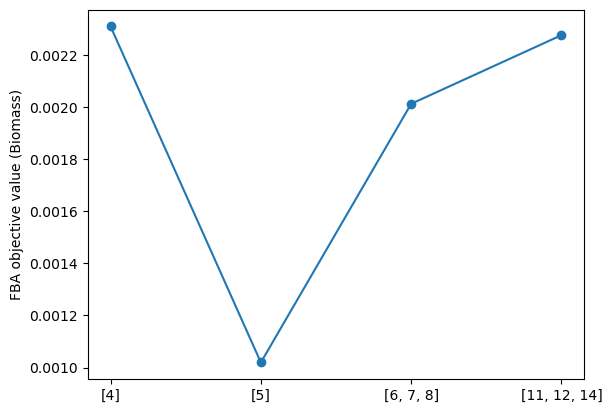

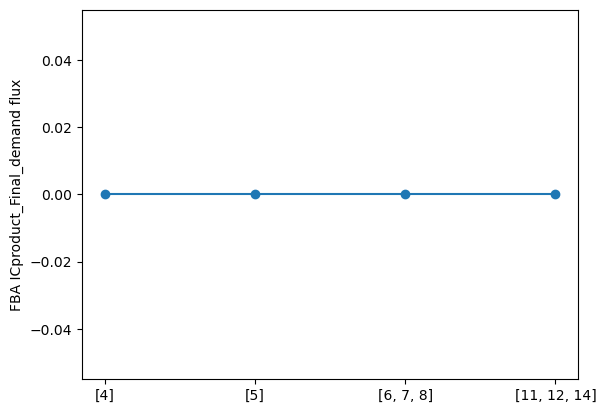

In [5]:
plt.plot(fba_solutions.keys(), [i.fluxes.biomass_cho_prod for i in fba_solutions.values()], marker = "o")
plt.ylabel("FBA objective value (Biomass)")
plt.show()

plt.plot(fba_solutions.keys(), [i.fluxes.ICproduct_Final_demand for i in fba_solutions.values()], marker = "o")
plt.ylabel("FBA ICproduct_Final_demand flux")
plt.show()

In [3]:
# Import Flux Sampling results.
phases = ["[4]",
          "[5]",
          "[6, 7, 8]",
          "[11, 12, 14]"
         ]
path = "fluxSamples_2441_results_phase{0}.csv"
fs_results = []
for i in phases:
    dat = pd.read_csv(path.format(i))
    dat["phase"] = i
    fs_results.append(dat.drop(dat.columns[0], axis = 1)) 
fs_results = pd.concat(fs_results)

In [ ]:
%store fs_results

In [4]:
%store dat

Stored 'dat' (DataFrame)


C:\Users\p04121km\AppData\Local\anaconda3\envs\prosperity_project\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\p04121km\AppData\Local\anaconda3\envs\prosperity_project\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\p04121km\AppData\Local\anaconda3\envs\prosperity_project\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\p04121km\AppData\Local\

<Axes: xlabel='biomass_cho_prod', ylabel='ICproduct_Final_demand'>

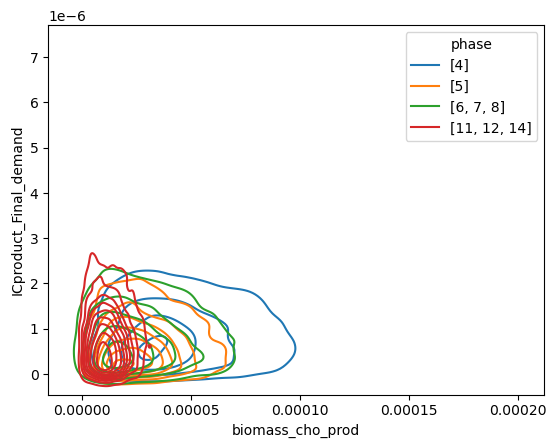

In [7]:
sns.kdeplot(fs_results, x = "biomass_cho_prod", y  = "ICproduct_Final_demand", hue = "phase")#, alpha= 0.5,col = "phase")

Plots looking at flux distribution of IgG ddemand and biomass are at bottom of notebook - for some reason running them before the other plotting functions makes them all mess up!!

# Identify high antibody production solutions.
i.e. solutions with ICproduct_Final_demand flux in 95 percentile 

In [ ]:
# filter high IgG solutions
phases = ["[4]",
          "[5]",
          "[6, 7, 8]",
          "[11, 12, 14]"
         ]

high_igg_solutions = {}

for i in range(len(phases)):
    dat = fs_results[fs_results["phase"] == phases[i]]
    dat = dat[dat["ICproduct_Final_demand"] >= np.percentile(dat["ICproduct_Final_demand"], 95)] # np.percentile(dat["ICproduct_Final_demand"], 95)
    high_igg_solutions[phases[i]] = dat

In [10]:
timephase_4_IgG_95th = np.percentile(high_igg_solutions['[4]']['ICproduct_Final_demand'], 95)
timephase_678_IgG_95th = np.percentile(high_igg_solutions['[6, 7, 8]']['ICproduct_Final_demand'], 95)
timephase_111214_IgG_95th = np.percentile(high_igg_solutions['[11, 12, 14]']['ICproduct_Final_demand'], 95)
print(timephase_4_IgG_95th, timephase_678_IgG_95th, timephase_111214_IgG_95th)
%store timephase_4_IgG_95th
%store timephase_678_IgG_95th
%store timephase_111214_IgG_95th

3.084916891149119e-06 3.420744926949763e-06 2.8004334542572083e-06
Stored 'timephase_4_IgG_95th' (float64)
Stored 'timephase_678_IgG_95th' (float64)
Stored 'timephase_111214_IgG_95th' (float64)


In [74]:
high_igg_solutions_drop_5 = {}
high_igg_solutions_drop_5['[4]'] = high_igg_solutions['[4]']
high_igg_solutions_drop_5['[6, 7, 8]'] = high_igg_solutions['[6, 7, 8]']
high_igg_solutions_drop_5['[11, 12, 14]'] = high_igg_solutions['[11, 12, 14]']

In [526]:
%store high_igg_solutions_drop_5

Stored 'high_igg_solutions_drop_5' (dict)


In [30]:
colors = []
for n in range(len(plt_dat)):
    if plt_dat.iloc[n,3] == '[4]':
        colors.append('red')
    if plt_dat.iloc[n,3] == '[6, 7, 8]':
        colors.append('lightgreen')
    if plt_dat.iloc[n,3] == '[11, 12, 14]':
        colors.append('violet')
plt_dat['colors'] = colors

PC1       PC2       PC3         phase
[4]          3    -0.237462 -0.216606  0.113811           [4]
             7    -0.215859 -0.248305  0.034563           [4]
             124  -0.321831 -0.189286 -0.037754           [4]
             150  -0.280460 -0.208482 -0.017625           [4]
             153  -0.266046 -0.221155 -0.012428           [4]
...                     ...       ...       ...           ...
[11, 12, 14] 4883  0.473047  0.016136  0.013121  [11, 12, 14]
             4906  0.546518 -0.013918 -0.035384  [11, 12, 14]
             4907  0.525116 -0.003302 -0.002141  [11, 12, 14]
             4957  0.481746 -0.014572 -0.060140  [11, 12, 14]
             4969  0.425503 -0.001494 -0.032518  [11, 12, 14]

[750 rows x 4 columns]

In [43]:
colour_dict = {'Early exponential':'red','Late exponential':'lightgreen','Stationary/death':'violet'}

explained variance ratio (first three components): [0.3779818  0.20463492 0.04765342]


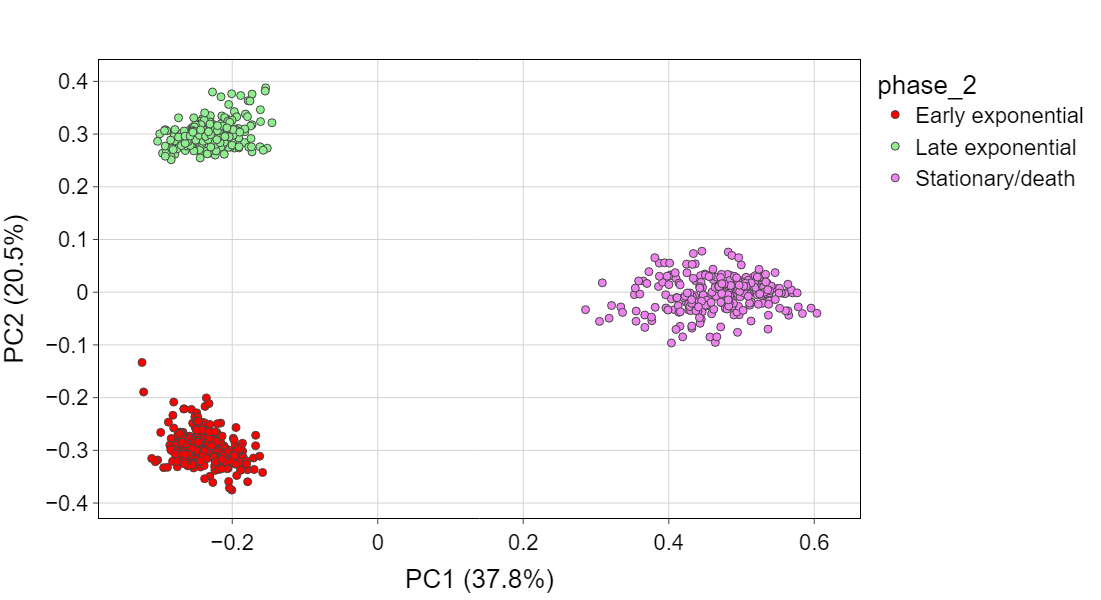

In [75]:
# PCA of high IgG solutions.

X = pd.concat(high_igg_solutions_drop_5).drop("phase",axis = 1).values
X = normalize(X)

pca = PCA(n_components=3)
pca.fit(X)
print("explained variance ratio (first three components): %s"
    % str(pca.explained_variance_ratio_)
)

# Create a LabelEncoder instance
label_encoder = LabelEncoder()
# Fit and transform the column to numeric values
class_labels = label_encoder.fit_transform(pd.concat(high_igg_solutions_drop_5)["phase"])

pca_dict = {f'PC{pc}': pca.transform(X)[:, i] for i, pc in enumerate(range(1, pca.n_components_ + 1))}
pca_dict.update({"phase":pd.concat(high_igg_solutions_drop_5)["phase"]})
plt_dat = pd.DataFrame(
    pca_dict
)
plt_dat


colors = []
for n in range(len(plt_dat)):
    if plt_dat.iloc[n,3] == '[4]':
        colors.append('red')
    if plt_dat.iloc[n,3] == '[6, 7, 8]':
        colors.append('lightgreen')
    if plt_dat.iloc[n,3] == '[11, 12, 14]':
        colors.append('violet')
plt_dat['colors'] = colors

new_phase = []
for n in range(len(plt_dat)):
    if plt_dat.iloc[n,3] == '[4]':
        new_phase.append('Early exponential')
    if plt_dat.iloc[n,3] == '[6, 7, 8]':
        new_phase.append('Late exponential')
    if plt_dat.iloc[n,3] == '[11, 12, 14]':
        new_phase.append('Stationary/death')
plt_dat['phase_2'] = new_phase    

fig = px.scatter(plt_dat, x='PC1', y='PC2', color='phase_2',color_discrete_map=colour_dict, width=800, height=600)
fig.update_traces(mode='markers', marker_line_width=1, marker_size=8)
fig.update_layout(xaxis_title='PC1 (37.8%)', yaxis_title='PC2 (20.5%)',
                 font_family='Arial',font=dict(size=22),font_color='black',plot_bgcolor='white')
fig.update_xaxes(showgrid=True, gridwidth=1,
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey',zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey'
)
fig.update_yaxes(showgrid=True, gridwidth=1,
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey',zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey'
)
fig.show()

I wanted to compare a few different statistical tests to see if the results changed much.
I compared:
 - Mann Whitney U test
 - Kolgomonov smirnov test
 - Permuted t-test 
 The permuted t-test was run in R for efficiency and the data was imported here. Below the MWU and KS test are run - takes under 5 mins to run

In [13]:
# Filter reactions that are signficantly skewed in high IgG vs population 

high_igg_stats = {
    "phase":[],
    "reaction":[],
    "fdr_ks":[],
    "fdr_mwu":[]
}


for i in high_igg_solutions.keys():

    # converted to np. format to allow vectorisation of ranksums calculation 
    flt_dat = high_igg_solutions[i].drop("phase",axis = 1).values
    dat = fs_results[fs_results["phase"] == i].drop("phase",axis = 1).values
    ks_p_values = ks_statistics = permut = mwu_p_values = mwu_statistics = np.zeros(dat.shape[1])
    for col in range(dat.shape[1]):
        x = flt_dat[:,col]
        y = dat[:,col]
        xy = (x,y)
        ks_statistics[col], ks_p_values[col] = stats.ks_2samp(x,y)
        mwu_statistics[col], mwu_p_values[col] = stats.mannwhitneyu(x, y)

    
    high_igg_stats["phase"] = high_igg_stats["phase"] + [i]*dat.shape[1] 
    high_igg_stats["reaction"] = high_igg_stats["reaction"] + list(high_igg_solutions[i].drop("phase",axis = 1).columns)
    high_igg_stats["fdr_ks"] = high_igg_stats["fdr_ks"]  + list(fdrcorrection(ks_p_values)[1])
    high_igg_stats["fdr_mwu"] = high_igg_stats["fdr_mwu"]  + list(fdrcorrection(mwu_p_values)[1])
high_igg_stats = pd.DataFrame(high_igg_stats)   

In [14]:
%store high_igg_stats

Stored 'high_igg_stats' (DataFrame)


In [12]:
permut_res = pd.read_csv("fluxSampling_highIgG_permutationTest.csv")

up_dat = {}
high_igg_stats_flt = high_igg_stats[(high_igg_stats["fdr_ks"] < 0.05) | (high_igg_stats["fdr_mwu"] < 0.05)]
high_igg_stats_flt = high_igg_stats_flt.melt(id_vars = ["phase", "reaction"], var_name = "test", value_name = "fdr")
high_igg_stats_flt = pd.concat([high_igg_stats_flt, permut_res])

for phase in phases:
    up_dat = {}
    for i in ["fdr_ks", "fdr_mwu", "fdr_permut"]:
        up_dat[i] = high_igg_stats_flt[(high_igg_stats_flt["test"] ==i) & (high_igg_stats_flt["phase"]== phase)]["reaction"]
    up_dat = up.from_contents(up_dat)
    up.plot(up_dat)
    plt.title(phase)

NameError: name 'high_igg_stats' is not defined

For all but one time phase, the MWU and KS test results are identical. 
The permutation test gives many more statistically signficiant results, probably meaning it is a less stringent measure.

Next, which reactions are differently regulated in high IgG solutions for each time phase?

C:\Users\p04121km\AppData\Local\anaconda3\envs\prosperity_project\Lib\site-packages\upsetplot\data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
C:\Users\p04121km\AppData\Local\anaconda3\envs\prosperity_project\Lib\site-packages\upsetplot\plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace

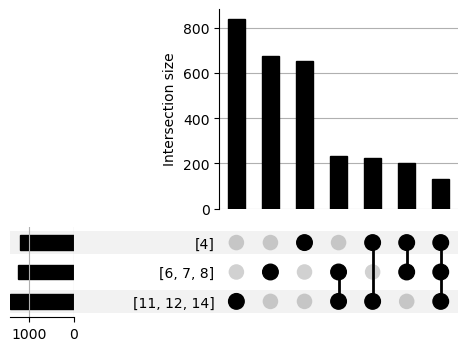

In [15]:
up_dat = {}
high_igg_stats_flt = high_igg_stats[(high_igg_stats["fdr_mwu"] < 0.05)]# & (high_igg_stats["fdr_skew"] < 0.05) & (high_igg_stats["highIgG_more_skewed"] == 1)]

for i in ["[4]", "[6, 7, 8]", "[11, 12, 14]"]:
    up_dat[i] = high_igg_stats_flt[high_igg_stats_flt["phase"] ==i]["reaction"]
up_dat = up.from_contents(up_dat)
up.plot(up_dat)
plt.show()

In [16]:
early = high_igg_stats_flt.loc[high_igg_stats_flt['phase'] == '[4]', 'reaction']
late = high_igg_stats_flt.loc[high_igg_stats_flt['phase'] == '[6, 7, 8]', 'reaction']
stationary = high_igg_stats_flt.loc[high_igg_stats_flt['phase'] == '[11, 12, 14]', 'reaction']
in_common = []
for e in early:
    for l in late:
        if e==l:
            for s in stationary:
                if l==s:
                    in_common.append(e)
print('number of reactions regulating antibody production shared across all time points:',len(in_common))

number of reactions regulating antibody production shared across all time points: 132


In [23]:
common_subsystems = {}
for s in in_common:
    if constrained_4.reactions.get_by_id(s).subsystem not in common_subsystems:
        if constrained_4.reactions.get_by_id(s).subsystem != '':
            common_subsystems[s] = constrained_4.reactions.get_by_id(s).subsystem

unique_subs = []
for k,v in common_subsystems.items():
    if v not in unique_subs:
        unique_subs.append(v)
print('number of diff subsytems associated with those reactions in common:',len(unique_subs))

number of diff subsytems associated with those reactions in common: 11


In [24]:
unique_subs

['Transport',
 'Nucelotide metabolism',
 'Exchange/demand/sink reaction',
 'Central carbon and energy metabolism',
 'Glycerophospholipid, sphingolipid and inositol metabolism',
 'Amino acid metabolism',
 'Other carbon metabolism',
 'Bile, eicosanoid and steroid metabolism',
 'Fatty acid metabolism',
 'Miscellaneous',
 'Glycan and glycosaminoglycan metabolism']

In [31]:
counts = {}
for n in range(len(unique_subs)):
    list = []
    for k,v in common_subsystems.items():
        if v == unique_subs[n]:
            list.append(k)
    counts[unique_subs[n]] = list
counts

{'Transport': ['ALACYSNaEx',
  'ALADGLYexR',
  'ALAGLNexR',
  'ALATHRNaEx',
  'ASNTHRNaEx',
  'CRVNCOAtx',
  'CSPG_At',
  'D_LACt2',
  'DNDPt53m',
  'FORMCOAtx',
  'FUCGALGBSIDEte',
  'FUCGALGBSIDEtg',
  'GALSIDEtg',
  'GALSIDEtl',
  'GTHRDtr',
  'MAL_Lte',
  'PHYTt',
  'TRDRDtm',
  'AAPAOC34',
  'YLAT2UT131',
  'YLAT2UT275',
  'YLAT2UT287',
  'AAPAOC131',
  '2HBBUTte',
  'TETTET6t',
  'THYOXt',
  'THYOXt2',
  'XOL7AONEtr',
  'TRDOXtm',
  'EICOSTETCOAtcx'],
 'Nucelotide metabolism': ['CSND', 'PUNP3', 'PUNP4', 'TRDRm'],
 'Exchange/demand/sink reaction': ['EX_acgalfucgalacgalfucgalacglcgal14acglcgalgluside_cho(e)',
  'EX_cspg_a(e)',
  'EX_cspg_d(e)',
  'EX_dgchol(e)',
  'EX_fmn(e)',
  'EX_lac_D(e)',
  'EX_leuktrC4(e)',
  'EX_mal_L(e)',
  'EX_phyt(e)',
  'EX_pi(e)',
  'EX_prostge2(e)',
  'EX_tettet6(e)',
  'EX_udp(e)',
  'ARTFR46'],
 'Central carbon and energy metabolism': ['FUMm', 'ICDHyrm'],
 'Glycerophospholipid, sphingolipid and inositol metabolism': ['FUT11g',
  'GLYC3PIPH',
  'GLYC3

In [38]:
for k,v in counts.items():
    print(k,':',len(v))

Transport : 30
Nucelotide metabolism : 4
Exchange/demand/sink reaction : 14
Central carbon and energy metabolism : 2
Glycerophospholipid, sphingolipid and inositol metabolism : 3
Amino acid metabolism : 1
Other carbon metabolism : 1
Bile, eicosanoid and steroid metabolism : 3
Fatty acid metabolism : 8
Miscellaneous : 1
Glycan and glycosaminoglycan metabolism : 1


In [59]:
in_common_11 = []
for k,v in common_subsystems.items():
    in_common_11.append(k)

In [80]:
transport = []
for r in model.reactions:
    if model.reactions.get_by_id(r.id).subsystem == 'Transport':
        transport.append(r.id)
print('there are',len(transport),'transport reactions in whole model')

there are 2245 transport reactions in whole model


In [62]:
high_igg_stats_flt_gprs_diff['reactions'] = high_igg_stats_flt_gprs_diff.index.to_list()
mask = high_igg_stats_flt_gprs_diff['reactions'].isin(in_common_11)
in_common_df = high_igg_stats_flt_gprs_diff[mask]
in_common_df

,phase,fdr_ks,fdr_mwu,direction,difference high igg/pop,subsystem,reactions
reaction,,,,,,,
ACOAD204n3p,"[11, 12, 14]",0.005815,0.005815,down,[0.39279184491745994],Fatty acid metabolism,ACOAD204n3p
3HAD204n3p,"[11, 12, 14]",0.001128,0.001128,down,[0.5552560166310371],Fatty acid metabolism,3HAD204n3p
3HDH204n3p,"[11, 12, 14]",0.001128,0.001128,down,[0.5552560166310394],Fatty acid metabolism,3HDH204n3p
ACACT204n3p,"[11, 12, 14]",0.001128,0.001128,down,[0.5552560166310417],Fatty acid metabolism,ACACT204n3p
FACOAL206,"[6, 7, 8]",0.000095,0.000095,down,[0.5709257991949086],Fatty acid metabolism,FACOAL206
...,...,...,...,...,...,...,...
TRDRm,"[11, 12, 14]",0.001219,0.001219,up,[1.464956932925309],Nucelotide metabolism,TRDRm
GLYC3PGPH,"[6, 7, 8]",0.015021,0.015021,up,[1.8704608488904642],"Glycerophospholipid, sphingolipid and inositol...",GLYC3PGPH
GLYC3PIPH,"[6, 7, 8]",0.015021,0.015021,up,[1.8704707327045464],"Glycerophospholipid, sphingolipid and inositol...",GLYC3PIPH


In [47]:
in_common_df.to_csv('in_common_df.csv')

There are many unique in each case time phase!!

In [351]:
fs_results_mean = fs_results.melt(id_vars = ["phase"], value_vars = fs_results.columns[:6334], var_name = "reaction", value_name = "flux")
fs_results_mean = fs_results_mean.groupby(['reaction', 'phase']).agg({'flux': 'mean'}).reset_index()
high_igg_mean = [i.melt(id_vars = ["phase"], value_vars = i.columns[:6334], var_name = "reaction", value_name = "flux") for i in high_igg_solutions.values()]
high_igg_mean = pd.concat([i.groupby(['reaction', 'phase']).agg({'flux': 'mean'}).reset_index() for i in high_igg_mean])

direction = []
diff = []
for index, row in high_igg_stats_flt.iterrows():
    pop_mean = fs_results_mean[(fs_results_mean["reaction"] == row["reaction"]) & (fs_results_mean["phase"] == row["phase"])]["flux"].values
    high_igg = high_igg_mean[(high_igg_mean["reaction"] == row["reaction"]) & (high_igg_mean["phase"] == row["phase"])]["flux"].values
    if abs(pop_mean) > abs(high_igg):
        direction.append("down")
    else:
        direction.append("up")
    diff.append(abs(high_igg) / abs(pop_mean))

high_igg_stats_flt["direction"] = direction
high_igg_stats_flt.loc[:,"difference high igg/pop"] = diff
high_igg_stats_flt["subsystem"] = [model.reactions.get_by_id(r).subsystem for r in high_igg_stats_flt["reaction"]]
high_igg_stats_flt
high_igg_stats_flt #= high_igg_stats_flt[(high_igg_stats_flt["difference high igg/pop"] > 2) | (high_igg_stats_flt["difference high igg/pop"] < 0.5)]
#high_igg_stats_flt.to_csv("../results/data/FluxSampling_highIgG_MannWhitney.csv")
#high_igg_stats_flt.to_csv("../results/data/FluxSampling_highIgG_KS.csv")

C:\Users\p04121km\AppData\Local\Temp\ipykernel_11704\2228738927.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\p04121km\AppData\Local\Temp\ipykernel_11704\2228738927.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\p04121km\AppData\Local\Temp\ipykernel_11704\2228738927.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

,phase,reaction,fdr_ks,fdr_mwu,direction,difference high igg/pop,subsystem
34,[4],2AMACHYD,2.468357e-08,2.468357e-08,down,[0.7297076456659047],Amino acid metabolism
35,[4],2AMACSULT,8.630969e-05,8.630969e-05,down,[0.834005505805533],Amino acid metabolism
37,[4],2AOBUTtm,2.104085e-02,2.104085e-02,up,[1.1490996630629102],Transport
43,[4],2OXOADPTm,1.318627e-03,1.318627e-03,down,[0.8646538549438237],Amino acid metabolism
44,[4],34DHOXPEGOX,2.750281e-02,2.750281e-02,down,[0.8345773616526712],Amino acid metabolism
...,...,...,...,...,...,...,...
25328,"[11, 12, 14]",SRP,8.782218e-122,8.782218e-122,up,[1.9594901405002527],
25329,"[11, 12, 14]",SRPR,8.782218e-122,8.782218e-122,up,[1.959490140500261],
25331,"[11, 12, 14]",SPC_degradation,5.777900e-10,5.777900e-10,up,[2.37308819280385],
25332,"[11, 12, 14]",co_TRANSLOC_7,8.782218e-122,8.782218e-122,up,[1.959490140500319],


In [352]:
high_igg_stats_flt_srt = high_igg_stats_flt.sort_values(by=['difference high igg/pop'])
high_igg_stats_flt_srt

,phase,reaction,fdr_ks,fdr_mwu,direction,difference high igg/pop,subsystem
3340,[4],OXALSUCCCLm,4.391223e-03,4.391223e-03,down,[0.021729647115261968],Central carbon and energy metabolism
23230,"[11, 12, 14]",PYRFORte,8.521601e-03,8.521601e-03,down,[0.026298565470450595],Transport
9064,[5],MM7B2g,3.068500e-07,3.068500e-07,down,[0.031474037643683124],Glycan and glycosaminoglycan metabolism
19758,"[11, 12, 14]",CRMPte,2.590605e-07,2.590605e-07,down,[0.03559842922493565],Transport
7064,[5],CO2tp,3.841650e-05,3.841650e-05,down,[0.045345863709876554],Transport
...,...,...,...,...,...,...,...
11490,[5],FACOAL2042,3.387832e-02,3.387832e-02,up,[50.60714939931825],Fatty acid metabolism
19824,"[11, 12, 14]",CYStec,6.914174e-04,6.914174e-04,up,[64.98522997970903],Transport
11713,[5],ACOAD204n6p,4.430267e-02,4.430267e-02,up,[177.69163764292242],Fatty acid metabolism
18963,"[6, 7, 8]",RAB1A_gdp_degradation,1.431673e-42,1.431673e-42,up,[196.9413710782841],


I picked the reaction below as an example case of the kind of changes we are looking for!!

C:\Users\p04121km\AppData\Local\anaconda3\envs\prosperity_project\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\p04121km\AppData\Local\anaconda3\envs\prosperity_project\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\p04121km\AppData\Local\anaconda3\envs\prosperity_project\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get

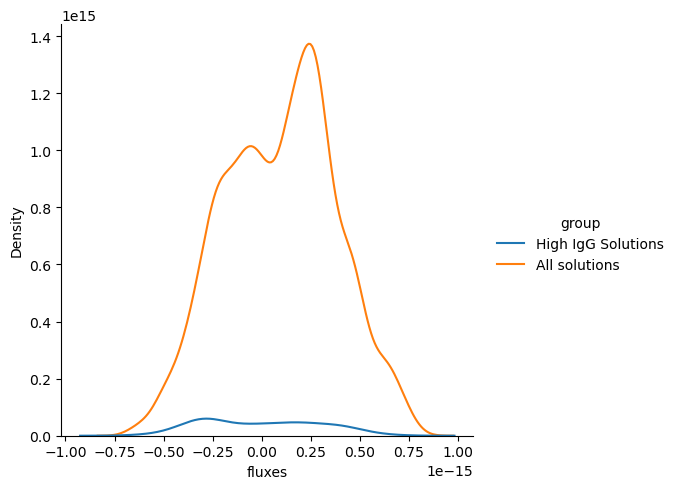

In [20]:
pltDat = pd.DataFrame({
    "fluxes": list(high_igg_solutions["[4]"]["LPS4e"]) + list(fs_results[fs_results["phase"]== "[4]"]["LPS4e"]),
    "group": ["High IgG Solutions"] * len(high_igg_solutions["[4]"]) + ["All solutions"] * len(fs_results[fs_results["phase"] == "[4]"])
})

sns.displot(pltDat, x = "fluxes", hue = "group", kind = "kde")

In [353]:
high_igg_stats_flt_srt_rxn = high_igg_stats_flt_srt.set_index('reaction')

In [354]:
with_gpr = []
for n in range(len(high_igg_stats_flt)):
    if len(model.reactions.get_by_id((high_igg_stats_flt_srt_rxn.index.to_list())[n]).gene_reaction_rule) > 0:
        with_gpr.append((high_igg_stats_flt_srt_rxn.index.to_list())[n])

to_drop = []
for n in range(len(high_igg_stats_flt)):
    if (high_igg_stats_flt_srt_rxn.index.to_list())[n] not in with_gpr:
        to_drop.append((high_igg_stats_flt_srt_rxn.index.to_list())[n])

high_igg_stats_flt_gprs = high_igg_stats_flt_srt_rxn.drop(to_drop)
high_igg_stats_flt_gprs

,phase,fdr_ks,fdr_mwu,direction,difference high igg/pop,subsystem
reaction,,,,,,
OXALSUCCCLm,[4],4.391223e-03,4.391223e-03,down,[0.021729647115261968],Central carbon and energy metabolism
PYRFORte,"[11, 12, 14]",8.521601e-03,8.521601e-03,down,[0.026298565470450595],Transport
MM7B2g,[5],3.068500e-07,3.068500e-07,down,[0.031474037643683124],Glycan and glycosaminoglycan metabolism
LPS4e,[4],1.302354e-05,1.302354e-05,down,[0.051258890538980036],"Glycerophospholipid, sphingolipid and inositol..."
C50CPT1,[4],1.822222e-02,1.822222e-02,down,[0.06208017381910143],Miscellaneous
...,...,...,...,...,...,...
PRISTCOAtcx,"[11, 12, 14]",3.350959e-02,3.350959e-02,up,[25.97910911530412],Transport
FACOAL2042,[5],3.387832e-02,3.387832e-02,up,[50.60714939931825],Fatty acid metabolism
ACOAD204n6p,[5],4.430267e-02,4.430267e-02,up,[177.69163764292242],Fatty acid metabolism


In [23]:
high_igg_stats_flt_gprs_mwu = high_igg_stats_flt_gprs.sort_values(by=['fdr_mwu'])
high_igg_stats_flt_gprs_mwu

,phase,fdr_ks,fdr_mwu,direction,difference high igg/pop,subsystem
reaction,,,,,,
SAR1B_activation,[4],9.174712e-140,9.174712e-140,up,[2.711316257444479],
RAB1A_activation,[5],9.174712e-140,9.174712e-140,up,[3.3079405378546483],
ICproduct_GOLGI_MGAT2,"[11, 12, 14]",9.174712e-140,9.174712e-140,up,[3.0187546106586356],
ICproduct_GOLGI_MAN1A,[4],9.174712e-140,9.174712e-140,up,[2.7113162574446856],
ICproduct_COPII_recruit_A,[4],9.174712e-140,9.174712e-140,up,[2.711316257444656],
...,...,...,...,...,...,...
3HDH181n9p,"[6, 7, 8]",4.973536e-02,4.973536e-02,down,[0.9136513826193866],Fatty acid metabolism
ACACT181n9p,"[6, 7, 8]",4.973536e-02,4.973536e-02,down,[0.9136513826193914],Fatty acid metabolism
CYTK3,"[6, 7, 8]",4.973536e-02,4.973536e-02,down,[0.9377411027646404],Nucelotide metabolism


In [350]:
%store -r high_igg_stats_flt_gprs_mwu

no stored variable or alias high_igg_stats_flt_gprs_mwu


In [ ]:
for n in range(len

In [24]:
high_igg_stats_flt_gprs_diff = high_igg_stats_flt_gprs.sort_values(by=['difference high igg/pop'], ascending=True)
%store high_igg_stats_flt_gprs_diff

Stored 'high_igg_stats_flt_gprs_diff' (DataFrame)


In [25]:
high_igg_stats_flt_gprs_diff

,phase,fdr_ks,fdr_mwu,direction,difference high igg/pop,subsystem
reaction,,,,,,
OXALSUCCCLm,[4],4.391223e-03,4.391223e-03,down,[0.021729647115261968],Central carbon and energy metabolism
PYRFORte,"[11, 12, 14]",8.521601e-03,8.521601e-03,down,[0.026298565470450595],Transport
MM7B2g,[5],3.068500e-07,3.068500e-07,down,[0.031474037643683124],Glycan and glycosaminoglycan metabolism
LPS4e,[4],1.302354e-05,1.302354e-05,down,[0.051258890538980036],"Glycerophospholipid, sphingolipid and inositol..."
C50CPT1,[4],1.822222e-02,1.822222e-02,down,[0.06208017381910143],Miscellaneous
...,...,...,...,...,...,...
PRISTCOAtcx,"[11, 12, 14]",3.350959e-02,3.350959e-02,up,[25.97910911530412],Transport
FACOAL2042,[5],3.387832e-02,3.387832e-02,up,[50.60714939931825],Fatty acid metabolism
ACOAD204n6p,[5],4.430267e-02,4.430267e-02,up,[177.69163764292242],Fatty acid metabolism


In [26]:
decreased = []
diff_index = high_igg_stats_flt_gprs_diff.index.to_list()

for n in range(len(high_igg_stats_flt_gprs_diff)):
    if high_igg_stats_flt_gprs_diff.iloc[n,4] < 1:
        decreased.append(diff_index[n])

print('number of reactions predicted to be downregulated in high-producing population:')
print(len(decreased))

number of reactions predicted to be downregulated in high-producing population:
2779


In [27]:
decreased

['OXALSUCCCLm',
 'PYRFORte',
 'MM7B2g',
 'LPS4e',
 'C50CPT1',
 'IVCOAACBP',
 'MM6B2g',
 'MM5cg',
 'THRGLYexR',
 'ACACT183n6p',
 'DDCI163n6p',
 'DECR163n6p',
 '3HAD183n6p',
 '3HDH183n6p',
 'ACOAD163n6p',
 'ANDRSTRNGLCte',
 'TMABADH',
 'BBHOX',
 'DUTPDPn',
 'THYMDtm',
 'CREATt4_2_r',
 'VLCSr',
 'NADK',
 'CLCFTRte',
 'BHB2HBte',
 'AATAi',
 'HDDACBP',
 'C12OHc',
 'N112SPRMO',
 'ACOAD224n6m',
 'LYStm',
 'TKT2',
 'TKT1',
 'ACOATE1832',
 'DLNLCGCPT2',
 '3HAD203n6m',
 'ACOAD203n6m',
 '3HDH203n6m',
 'DLNLCGCPT1',
 'ACACT203n6m',
 'DLNLCGCRNt',
 'C81_5ZCPT2m',
 'C81CRNtm',
 'PPABUTte',
 'PROSTGA2t5e',
 'ICDHxrm',
 'TXASr',
 'C81_5ZCPTx',
 'ALATA_L',
 'GTPCI',
 'PI45P5P',
 '5ADTSTSTERONESULT',
 'PIt7',
 'MI134PK',
 'ENMAN5g',
 'PROSTGH2t5e',
 'DNPH3',
 'AAPAOC92',
 'GGH_5THFe',
 'ACOAD204n3p',
 'TMNDNCCRNt',
 'TMNDNCCPT2',
 'TMNDNCCPT1',
 'PIt9',
 'RDH2a',
 '3M4HPORy',
 '3M4HPORx',
 'GALASE20ly',
 'S6TASE25ly',
 'S6TASE26ly',
 'NACHEX26ly',
 'SIAASE4ly',
 'ALATA_Lm',
 'ALAGLYexR',
 'FACOAL184',
 

In [28]:
%store decreased

Stored 'decreased' (list)


In [29]:
%store -r decreased

##### Simulate knockouts of these reactions which are downreg in high-producing
##### These could be potential knockdown targets for increasing productivity

In [30]:
# need to know which time point this reaction is downreg in so I can integrate with this data
# could simulate the knockdown at each time point and store before and after result
# store results as a dataframe then filter this for those which increase productivity

Which metabolic subsystems do these sets of reactions belong to?

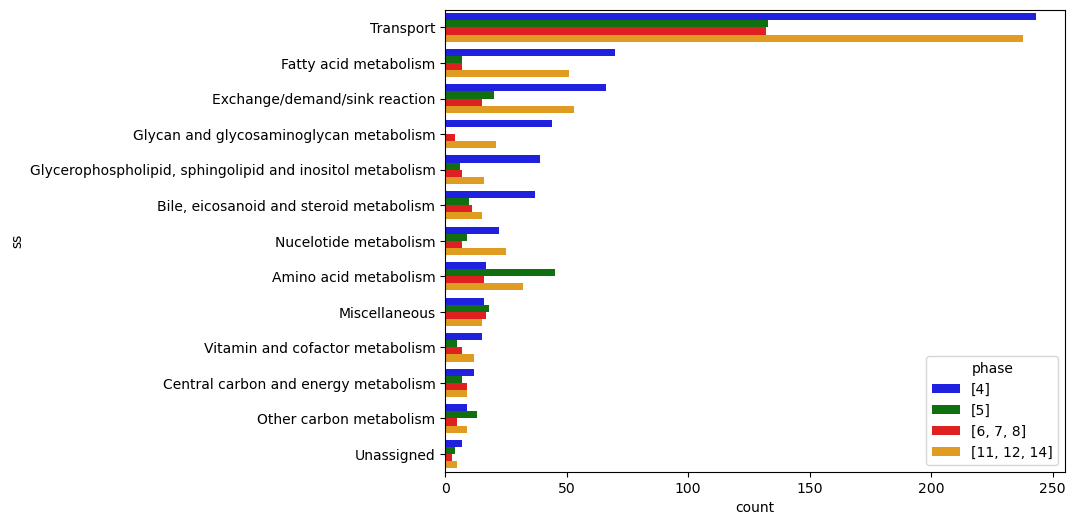

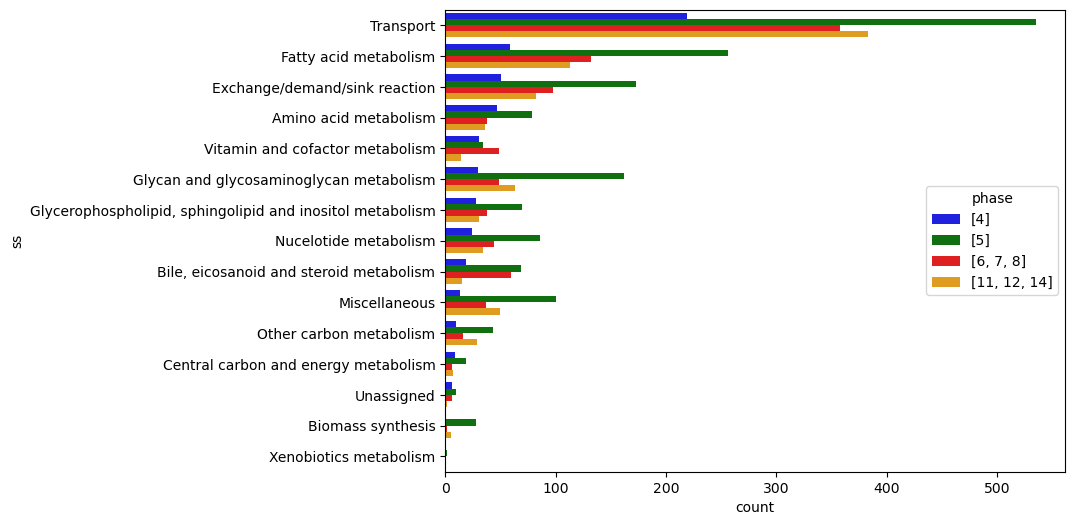

In [31]:
from collections import Counter

cols = ["blue", "green", "red", "orange"]
custom_palette = {}
for i in range(len(phases)):
    custom_palette[phases[i]] = cols[i]

for direction in ["up", "down"]:
    forDF = []
    for phase in phases:
        flt_dat = high_igg_stats_flt[high_igg_stats_flt["phase"] == str(phase)]
        flt_dat = flt_dat[flt_dat["direction"] == direction]
        flt_dat = flt_dat[flt_dat["subsystem"] != ""]
        phase_ss =  Counter(flt_dat["subsystem"]).most_common()
    
#    phase_ss_flt = {}
#    for ss in phase_ss.keys():
#        if phase_ss[ss] > 1:
#            phase_ss_flt[ss] = phase_ss[ss]
        phase_ss_flt = pd.DataFrame({
            "ss":[i[0] if i[1] > 1 else None for i in phase_ss],
            "count":[i[1] if i[1] > 1 else None for i in phase_ss],
            "phase":str(phase),
            "direction":direction
        })
        forDF.append(phase_ss_flt.dropna())
    forDF = pd.concat(forDF)
    plt.figure(figsize=(8, 6))
    sns.barplot(forDF, x = "count", y = "ss", hue = "phase", palette = custom_palette)
    plt.show()

Export data for prettier visualisation with ggplot2/R:

In [32]:
phases_ss_genes = []
for phase in phases:
#   phases_ss_genes[phase] = {}
    phase_dat = high_igg_stats_flt[high_igg_stats_flt["phase"] == phase]

    for ss in phase_dat["subsystem"].unique():
        # phases_ss_genes[phase][ss] = []
        for direction in ["up", "down"]:
            tmp = phase_dat[(phase_dat["direction"] == direction) & (phase_dat["subsystem"] == ss)]

            # Extract unique reactions for the current subsystem and direction
            reactions = tmp["reaction"].unique()

            # Filter transcriptome data for genes related to the reactions
            genes = [g.id for r in reactions for g in model.reactions.get_by_id(r).genes if g.id in list(transcriptomeData_sig_scaled["GeneID"])]
            n = len(list(set(genes)))
            genes = ";".join(list(set(genes)))

            if len(genes) > 0:
                dat = pd.DataFrame({
                    "phase":phase,
                    "subsystem":ss,
                    "direction":direction,
                    "GeneID": genes,
                    "n":n
                }, index = [1])
                phases_ss_genes.append(dat)

pd.concat(phases_ss_genes).to_csv("../results/data/fluxSampling_highIgG_subsystems_genes.csv")



OSError: Cannot save file into a non-existent directory: '..\results\data'

C:\Users\p04121km\AppData\Local\anaconda3\envs\prosperity_project\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\p04121km\AppData\Local\anaconda3\envs\prosperity_project\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\p04121km\AppData\Local\anaconda3\envs\prosperity_project\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\p04121km\AppData\Local\anaconda3\envs\prosperity_project\Lib\site-pack

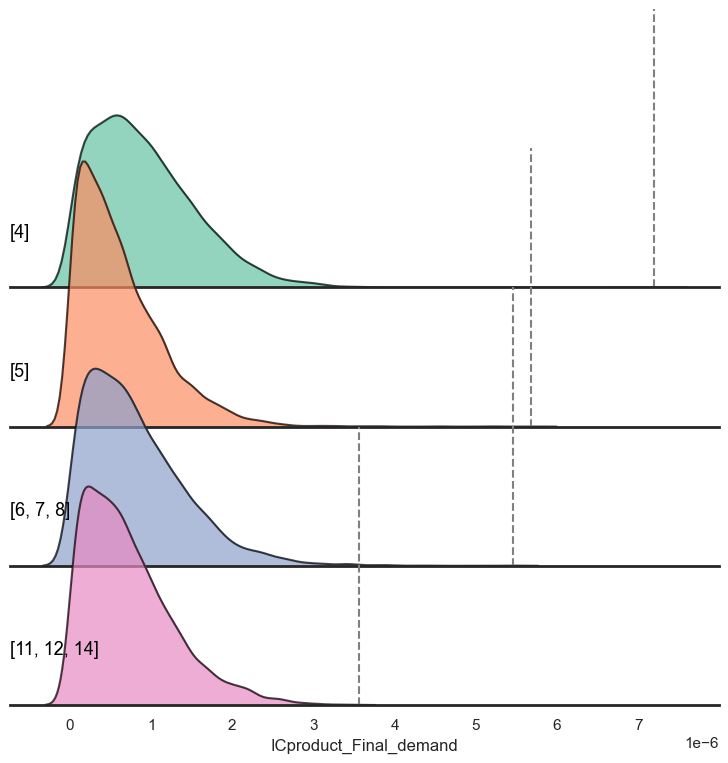

In [9]:
df_filtered=fs_results.loc[:,['ICproduct_Final_demand', 'phase']]
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})
palette = sns.color_palette("Set2", 12)
g = sns.FacetGrid(df_filtered, palette=palette, row="phase", hue="phase", aspect=4, height=2)
g.map_dataframe(sns.kdeplot, x="ICproduct_Final_demand", fill=True, alpha=0.7)
g.map_dataframe(sns.kdeplot, x="ICproduct_Final_demand", color='black', alpha = 0.7)
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, color='black', fontsize=13,
            ha="left", va="center", transform=ax.transAxes)
g.map(label, "phase")
g.fig.subplots_adjust(hspace=-.5)
g.set_titles("")
g.set(yticks=[], xlabel="ICproduct_Final_demand", ylabel=None)
g.despine( left=True)

# Calculate and plot the 95th percentile
for ax in g.axes.flat:
    data = ax.lines[0].get_xdata()
    p = np.percentile(data, 95)
    ax.axvline(x=p, color='grey', linestyle='--')  # Vertical line at the 99th percentile
    # or
    # plt.scatter(p99, 0, marker='o', color='red')  # Point at the 99th percentile


C:\Users\p04121km\AppData\Local\anaconda3\envs\prosperity_project\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\p04121km\AppData\Local\anaconda3\envs\prosperity_project\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\p04121km\AppData\Local\anaconda3\envs\prosperity_project\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\p04121km\AppData\Local\anaconda3\envs\prosperity_project\Lib\site-pack

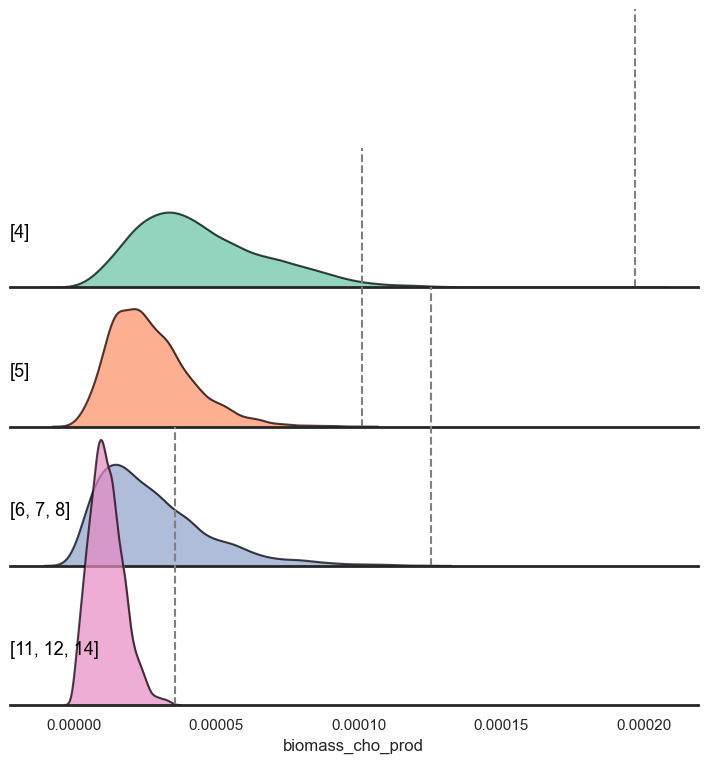

In [10]:
df_filtered=fs_results.loc[:,['biomass_cho_prod', 'phase']]
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})
palette = sns.color_palette("Set2", 12)
g = sns.FacetGrid(df_filtered, palette=palette, row="phase", hue="phase", aspect=4, height=2)
g.map_dataframe(sns.kdeplot, x="biomass_cho_prod", fill=True, alpha=0.7)
g.map_dataframe(sns.kdeplot, x="biomass_cho_prod", color='black', alpha = 0.7)
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, color='black', fontsize=13,
            ha="left", va="center", transform=ax.transAxes)
g.map(label, "phase")
g.fig.subplots_adjust(hspace=-.5)
g.set_titles("")
g.set(yticks=[], xlabel="biomass_cho_prod", ylabel=None)
g.despine( left=True)

# Calculate and plot the 95th percentile
for ax in g.axes.flat:
    data = ax.lines[0].get_xdata()
    p = np.percentile(data, 95)
    ax.axvline(x=p, color='grey', linestyle='--')  # Vertical line at the 99th percentile
    # or
    # plt.scatter(p99, 0, marker='o', color='red')  # Point at the 99th percentile


<Axes: xlabel='phase', ylabel='ICproduct_Final_demand'>

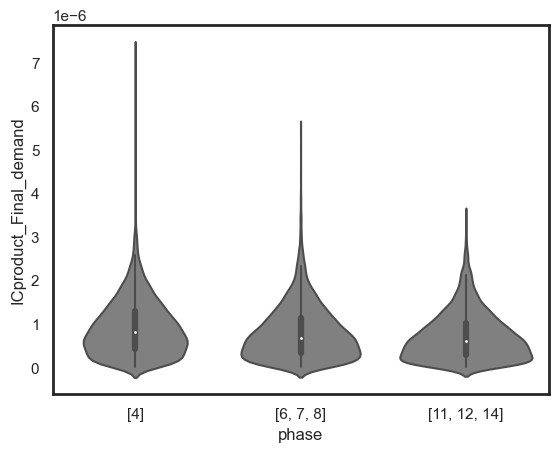

In [83]:
df_filtered_2 = df_filtered[df_filtered.phase != '[5]']
palette_dict = {'[4]':3,'[6, 7, 8]':4,'[11, 12, 14]':5}
sns.violinplot(data=df_filtered_2, x='phase', y='ICproduct_Final_demand', color='grey')